<a href="https://colab.research.google.com/github/jacr2006/tensorboard/blob/master/graph_tensorboard.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##Perceptron

El propósito de este notebook es entrenar un Perceptrón (Red Neuronal de una capa) para un problema de clasificación multiclase de digitos escritos a mano. Finalmente se tratará de inferir la clase a la que pertenece una imagen de un digito escritos a mano. Para el entrenamiento usaremos el dataset MNIST conformado por 60.000 imagenes de entrenamiento y 10.000 imagenes de prueba.

Es posible usar un Perceptron para este problema porque de antemano sabemos que el conjunto de entranamiento el linealmente separable.
Este dataset esta disponible en la libreria "tensorflow_datasets" de tensorflow.

In [30]:
!pip install tensorboardcolab

Importar las librerias necesarias

In [0]:
import tensorflow as tf
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt

In [0]:
tf.reset_default_graph()

###Datos
En este dataset la data de entrada es un conjunto imagenes que estan centradas y estandarizadas en tamaño (28X28x1 pixels, en blanco y negro), no es requerida limpieza de los datos. La data de salida esta conformada por un conjuto finito de datos etiquetados entre el valor 0 y el 9, data categórica.
Lectura de los datos de entrenamiento

In [0]:
train_ds = tfds.load("mnist", split=tfds.Split.TRAIN, batch_size=-1)
numpy_ds = tfds.as_numpy(train_ds)
numpy_images, numpy_labels = numpy_ds["image"], numpy_ds["label"]

In [34]:
numpy_images.shape

(60000, 28, 28, 1)

Como la entrada al Perceptron debe ser de una dimension, se requiere una transformacion de la data de entrada de 60000x28x28x1 a 60000x784

In [0]:
width = 28 # ancho de la imagen en pixels
height = 28 # altura de la imagen en pixels
flat = width * height # numero de pixels de la imagen
class_output = 10 # numero de clases

In [0]:
numpy_images=numpy_images.reshape(60000,flat)

In [37]:
numpy_images.shape

(60000, 784)

La siguiente figura muestra la imagen de un numero perteneciente al conjunto de entrenamiento

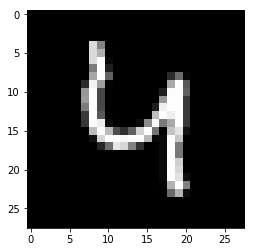

In [38]:
image_index = 42 
img=numpy_images[image_index].reshape(width,height)
plt.imshow(img, cmap="gray")

In [39]:
numpy_labels.shape

(60000,)

Lectura de los datos de prueba

In [0]:
test_ds = tfds.load("mnist", split=tfds.Split.TEST, batch_size=-1)
numpy_ds_test = tfds.as_numpy(test_ds)
numpy_images_test, numpy_labels_test = numpy_ds_test["image"], numpy_ds_test["label"]

In [41]:
numpy_images_test.shape

(10000, 28, 28, 1)

In [42]:
numpy_images_test=numpy_images_test.reshape(10000,flat)
numpy_images_test.shape

(10000, 784)

In [0]:
sess = tf.InteractiveSession()#se crea una sesion interativa, ideal para notebooks

Los algoritmos de "machine learning" no funcionan bien con data categorica directamente. Por tanto, se deben codificar estas categorias numéricas en vectores binarios. Para este caso donde existen 10 clases de salida representadas por un valor decimal entre 0 y 9. Se codificaran en un vector binario 1x10 donde solo existe una columna con un valor 1 mientras el resto son 0.

In [0]:
numpy_labels=tf.one_hot(numpy_labels, depth=class_output)
labels=sess.run(numpy_labels)

In [45]:
labels.shape

(60000, 10)

Se realiza la misma codificación para el conjunto de prueba

In [0]:
numpy_labels_test=tf.one_hot(numpy_labels_test, depth=class_output)
labels_test=sess.run(numpy_labels_test)

In [47]:
labels_test.shape

(10000, 10)

###Entrenamiento
Se crean "placeHolders" para la variables de entrada (x) y la de salida (y_).

In [0]:
x  = tf.placeholder(tf.float32, shape=[None, flat], name="x")
y_ = tf.placeholder(tf.float32, shape=[None, class_output], name="y_")

Se crean las variables del modelo del perceptron y = x * W + b, donde (x) son las imagenes y (y) las etiquetas. W y b son los pesos y bias del modelo respectivamente

In [0]:
W = tf.Variable(tf.zeros([flat, class_output],tf.float32), name="W")
b = tf.Variable(tf.zeros([class_output],tf.float32), name="b")

In [0]:
sess.run(tf.global_variables_initializer())

Por definicion el Perceptron utiliza como función de activación "softmax"

In [0]:
with tf.name_scope('net'):
  y = tf.nn.softmax(tf.add(tf.matmul(x,W), b))

In [0]:
with tf.name_scope('cost'):
  cross_entropy = tf.reduce_mean(-tf.reduce_sum(y_ * tf.log(y), reduction_indices=[1]), name="cross_entrophy")

Para este caso, se usa Gradiente Descendente como algoritmo de optimización

In [0]:
learning_rate=1e-5#se selecciona un "learning rate" pequeño, y se observa la convergencia

with tf.name_scope('optimization'):
  optimizer=tf.train.GradientDescentOptimizer(learning_rate)
  train_step = optimizer.minimize(cross_entropy)
  tf_loss_summary = tf.summary.scalar('loss', cross_entropy)

with tf.name_scope('accuracy'):  
  prediction_training = tf.equal(tf.argmax(y, 1), tf.argmax(y_, 1))#se calcula la precision para cada nuevos parametros calculados en el entreanamiento
  accuracy_training = tf.reduce_mean(tf.cast(prediction_training, tf.float32))
  tf_acc_summary = tf.summary.scalar('accuracy', accuracy_training)

performance = tf.summary.merge([tf_loss_summary, tf_acc_summary])

Se crea un objeto tensorboard que crea un link

In [54]:
from tensorboardcolab import * 
tbc = TensorBoardColab() 
writer = tbc.get_writer()

Wait for 8 seconds...
TensorBoard link:
http://abee027d.ngrok.io


Se ejecutan un conjunto finito de iteraciones, y se analiza la convergencia mediendo la diferencia entre dos sucesivos valores de costo

In [55]:
cost=0
with tf.name_scope('training'):
  for i in range(500):
    step, new_cross_entropy, new_W, new_b = sess.run([train_step, cross_entropy, W, b], feed_dict={x: numpy_images, y_: labels})
    diff=abs(cost-new_cross_entropy)
    cost=new_cross_entropy
    
    summ = sess.run(performance, feed_dict={x: numpy_images, y_: labels})
    writer.add_summary(summ, i)
    
    if i%10==0:
      print("Paso: {}, Costo: {}".format(i, new_cross_entropy) )
    if i > 1 and diff < .001:#usamos un criterio de convergencia de 10-3 para finalizar el entrenamiento
      print("El entrenamiento converge")
      break
      
#writer.add_graph(sess.graph)
writer.add_graph(tf.get_default_graph())
writer.flush() 

Paso: 0, Costo: 2.3025853633880615
Paso: 10, Costo: 0.7526967525482178
Paso: 20, Costo: 0.5523132681846619
Paso: 30, Costo: 0.49068164825439453
Paso: 40, Costo: 0.4561556279659271
Paso: 50, Costo: 0.43303775787353516
Paso: 60, Costo: 0.4161933958530426
Paso: 70, Costo: 0.4032211899757385
El entrenamiento converge


Se determina la precision del modelo con los datos del conjunto de prueba

In [56]:
with tf.name_scope('test'):
  prediction = tf.equal(tf.argmax(y, 1), tf.argmax(y_, 1))
  accuracy_test = tf.reduce_mean(tf.cast(prediction, tf.float32))*100
  resul=tf.print("La precision del modelo es:", accuracy_test)
  resul=sess.run(resul, feed_dict={x: numpy_images_test, y_: labels_test} )   

La precision del modelo es: 90.0600052


###Inferencia
Con los parametros del modelo ya obtenidos (ultimos W y b), se selecciona una imagen aleatoria del conjunto de prueba y se hace pasar a traves del modelo

El valor inferido es: [4]


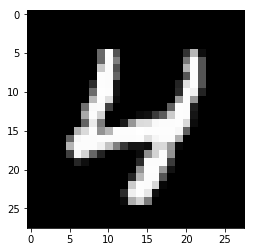

In [57]:
image_index = 567
img=numpy_images_test[image_index].reshape(width,height)
plt.imshow(img, cmap="gray")

prediction=tf.nn.softmax( tf.add( tf.matmul( tf.cast(tf.expand_dims( numpy_images_test[image_index],0), tf.float32), tf.cast(new_W, tf.float32) ), new_b ) )
encode=tf.argmax(prediction, axis=1)#la predicion obtenida es un vector binario, se debe codificar a un valor numérico
res=tf.print("El valor inferido es:", encode)
sess.run(res)

In [0]:
sess.close() 